In [ ]:
import orbit #общий пакет
from orbit.models import DLT #один из вариантов модели
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования предсказаний

#общие штуки для кручения данных
import pandas as pd
import pandahouse as ph
import numpy as np
import os

#общие штуки для рисования
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az #это полезно для визуализации MCMC

import tensorflow as tf
import tensorflow_probability as tfp

from causalimpact import CausalImpact
import causalimpact

In [2]:
import karpov_secrets as ks

#параметры соединения
connection = ks.connection

# Flasmob impact

Допустим, флэшмоб повлияет на:
1. DAU - больше пользователей станет посещать приложение для написания постов, чтобы получить приз
2. Количество уникальных постов - люди, которые раньше ничего не постиили будут писать о себе и увеличат кол-во постов
3. Количество просмотров и лайков вырастет, а вот ctr под вопросом

In [4]:
#текст запроса
query = '''
select t1.time time, dau, posts_posted, likes, views, registrations, mess_sent
from (
select
    toDate(time) time,
    uniqExact(user_id) dau,
    uniqExact(post_id) posts_posted,
    countIf(user_id, action='like') likes,
    countIf(user_id, action='view') views
from simulator_20230820.feed_actions
where time > '2023-07-03' and time <= '2023-08-26'
group by time) t1

JOIN
(select time, uniqExact(user_id) as registrations
from (
    select
        user_id, toDate(time) as time,
        min(toDate(time)) over (partition by user_id) as reg_day
    from simulator_20230820.feed_actions
    where time > '2023-07-03' and time <= '2023-08-26'
)
where time = reg_day
group by time) t2 on t1.time = t2.time

JOIN
(select toDate(time) as time, count() as mess_sent
from simulator_20230820.message_actions
where time > '2023-07-03' and time <= '2023-08-26'
group by time) t3 on t1.time = t3.time
'''

# эта функция выполнит запрос и запишет его результат в pandas DataFrame
df = ph.read_clickhouse(query, connection=connection)

In [5]:
#df['avg_likes'] = df.likes / df.posts_posted
#f['avg_views'] = df.views / df.posts_posted
df['ctr'] = df.likes / df.views
normed_data, _ = causalimpact.misc.standardize(df.drop("time", axis=1).astype(np.float32))
df = df.set_index('time')

In [6]:
df.head()

,dau,posts_posted,likes,views,registrations,mess_sent,ctr
time,,,,,,,
2023-07-04,2238,178,12816,62770,2238,12895,0.204174
2023-07-05,3105,191,20958,105526,2040,12897,0.198605
2023-07-06,3721,211,23800,118996,1757,12897,0.200007
2023-07-07,4617,214,34504,174454,1873,12898,0.197783
2023-07-08,4728,221,33604,168419,1301,12899,0.199526


Флэшмоб проходил с 2023-08-13 по 2023-08-19

In [7]:
pre_period=[pd.Timestamp("2023-07-04"), 
            pd.Timestamp("2023-08-12")]
post_period=[pd.Timestamp("2023-08-13"),
            pd.Timestamp("2023-08-19")]

### Влияние на количество просмотров

In [8]:
trend_component_views = tfp.sts.LocalLinearTrend(observed_time_series=normed_data.views[:40])

In [9]:
views_ic = CausalImpact(data=df.views, 
                            pre_period=pre_period,
                            post_period=post_period,
                            model=trend_component_views)

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


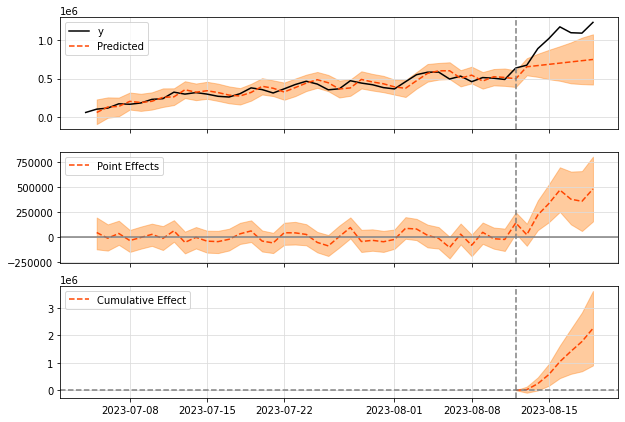

In [10]:
views_ic.plot()

In [11]:
print(views_ic.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 1019947.31. By contrast, in the absence of an
intervention, we would have expected an average response of 698703.06.
The 95% interval of this counterfactual prediction is [503959.5, 919661.67].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 321244.25 with a 95% interval of
[100285.64, 515987.82]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 7139631.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 4890921.5. The 95% interval of this prediction is [3527716.47, 6437631.65].


The above results are given in terms of absolute numbe

Кол-во просмотров постов в днеь выросло практически в 1.5 раза с 698к до 1019к, доверительный интервал эффекта [114к, 541к]

### Likes

In [12]:
trend_component_likes = tfp.sts.LocalLinearTrend(observed_time_series=normed_data.likes[:40])

In [13]:
likes_ic = CausalImpact(data=df.likes, 
                            pre_period=pre_period,
                            post_period=post_period,
                            model=trend_component_likes)

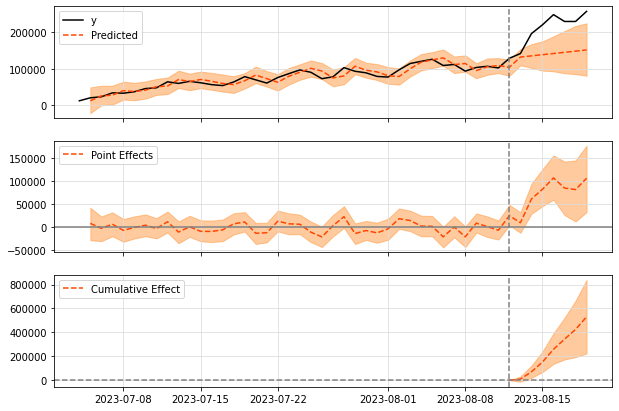

In [14]:
likes_ic.plot()

In [15]:
print(likes_ic.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 218090.14. By contrast, in the absence of an
intervention, we would have expected an average response of 142325.33.
The 95% interval of this counterfactual prediction is [97507.56, 191972.21].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 75764.81 with a 95% interval of
[26117.93, 120582.58]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1526631.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 996277.31. The 95% interval of this prediction is [682552.87, 1343805.49].


The above results are given in terms of absolute numbers. 

Кол-во лайков, собранных постами за днеь, выросло на 51% с 143к до 218к, доверительный интервал эффекта [18к, 116к]

### CTR

In [16]:
trend_component_ctr = tfp.sts.LocalLinearTrend(observed_time_series=normed_data.ctr[:40])

In [17]:
ctr_ic = CausalImpact(data=df.ctr, 
                            pre_period=pre_period,
                            post_period=post_period,
                            model=trend_component_ctr)

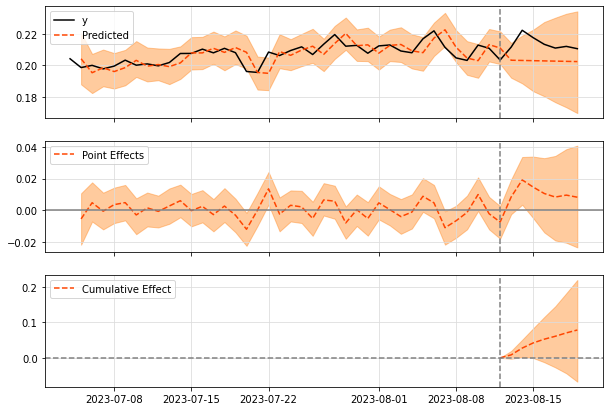

In [18]:
ctr_ic.plot()

In [19]:
print(ctr_ic.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.21. In the absence of an
intervention, we would have expected an average response of 0.2.
The 95% interval of this counterfactual prediction is [0.18, 0.22].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.01 with a 95% interval of
[-0.01, 0.03]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1.5.
Had the intervention not taken place, we would have expected
a sum of 1.42. The 95% interval of this prediction is [1.27, 1.55].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase of +5.52%. The 95%
i

Флэшмоб не повлиял на ctr достаточно сильно, чтобы casual impact заметил стат значимую разницу

### DAU

In [20]:
trend_component_dau = tfp.sts.LocalLinearTrend(observed_time_series=normed_data.dau[:40])

In [21]:
dau_ic = CausalImpact(data=df.dau, 
                            pre_period=pre_period,
                            post_period=post_period,
                            model=trend_component_dau)

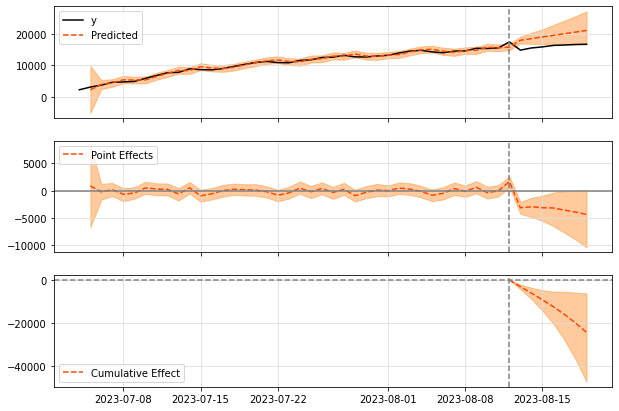

In [22]:
dau_ic.plot()

In [23]:
print(dau_ic.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 16052.71. By contrast, in the absence of an
intervention, we would have expected an average response of 19533.27.
The 95% interval of this counterfactual prediction is [16939.99, 23078.69].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -3480.55 with a 95% interval of
[-7025.97, -887.28]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 112369.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 136732.88. The 95% interval of this prediction is [118579.92, 161550.8].


The above results are given in terms of absolute numbers. In relat

Marketing day который проходил 12 августа увеличил dau в этот день, из-за этого модель переоценила будущие значения и показала, что флэшмоб фактически понизил активную аудиторию.

Чтобы это исправить, заменим значение dau 12 августа на среднее между значениями 11 и 13 августа

In [24]:
df_correrct = df[['dau', 'likes']]

In [25]:
df_correrct.loc[df_correrct.index == '2023-08-12', "dau"] = df_correrct[(df_correrct.index == '2023-08-11') | (df_correrct.index == '2023-08-13')].dau.mean()

/tmp/ipykernel_52/1511560552.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_correrct.loc[df_correrct.index == '2023-08-12', "dau"] = df_correrct[(df_correrct.index == '2023-08-11') | (df_correrct.index == '2023-08-13')].dau.mean()


In [26]:
normed_data_dau, _ = causalimpact.misc.standardize(df_correrct.reset_index(drop=True).astype(np.float32))

In [27]:
trend_component_dau_corrected = tfp.sts.LocalLinearTrend(observed_time_series=normed_data_dau.dau[:40])

In [28]:
dau_corrected_ic = CausalImpact(data=df_correrct.dau, 
                            pre_period=pre_period,
                            post_period=post_period,
                            model=trend_component_dau_corrected)

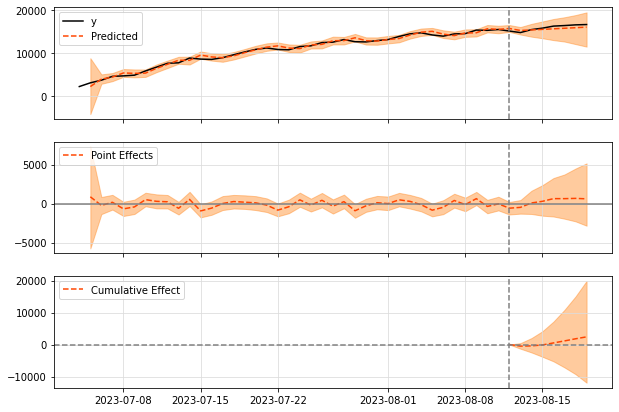

In [29]:
dau_corrected_ic.plot()

In [30]:
print(dau_corrected_ic.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 16052.71. In the absence of an
intervention, we would have expected an average response of 15708.89.
The 95% interval of this counterfactual prediction is [13222.95, 17769.75].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 343.83 with a 95% interval of
[-1717.03, 2829.76]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 112369.0.
Had the intervention not taken place, we would have expected
a sum of 109962.21. The 95% interval of this prediction is [92560.68, 124388.23].


The above results are given in terms of absolute numbers. In relative
terms, the response vari

На скорректированном dau CasualImpact не видит влияния флэшмоба на метрику

### Кол-во постов в приложении

In [31]:
trend_component_posts = tfp.sts.LocalLinearTrend(observed_time_series=normed_data.posts_posted[:40])
posts_ic = CausalImpact(data=df.posts_posted, 
                            pre_period=pre_period,
                            post_period=post_period,
                            model=trend_component_posts)

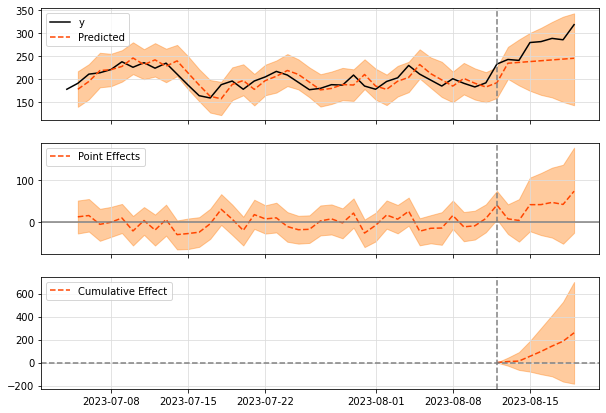

In [32]:
posts_ic.plot()

In [33]:
print(posts_ic.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 277.14. In the absence of an
intervention, we would have expected an average response of 240.23.
The 95% interval of this counterfactual prediction is [177.4, 304.83].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 36.92 with a 95% interval of
[-27.68, 99.74]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1940.0.
Had the intervention not taken place, we would have expected
a sum of 1681.58. The 95% interval of this prediction is [1241.79, 2133.78].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increa

### Долгосрочный эффект

In [34]:
trend_component_likes_long = tfp.sts.LocalLinearTrend(observed_time_series=normed_data.likes[:48])
likes_long_ic = CausalImpact(data=df.likes, 
                            pre_period=[pd.Timestamp("2023-07-04"), 
                                        pd.Timestamp("2023-08-19")],
                            post_period=[pd.Timestamp("2023-08-20"),
                                        pd.Timestamp("2023-08-26")],
                            model=trend_component_likes_long)

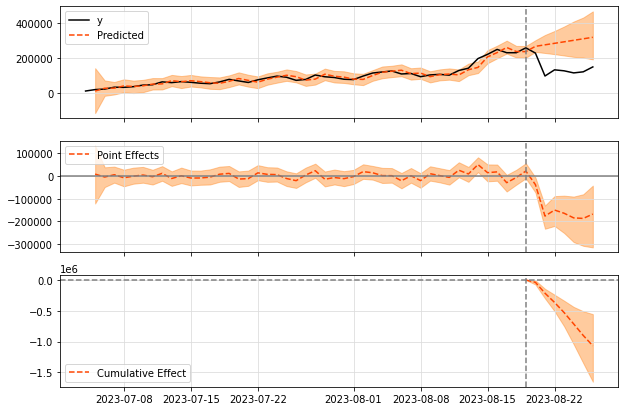

In [35]:
likes_long_ic.plot()

### Вывод

Флэшмоб повысил количество постов в приложении на 9%, но доверительный интервал слишком велик (и включает 0), чтобы говорить о казуальной связи флэшмоба и роста данной метрики

Также выросло кол-во просмотров постов в день практически в 1.5 раза с 698к до 1019к, доверительный интервал эффекта [114к, 541к]

Выросло и количество лайков собранных постами за днеь, на 51% с 143к до 218к, доверительный интервал эффекта [18к, 116к], но больше из-за роста кол-ва просмотров, так как ctr не вырос.

Как не изменился и DAU - во флэшмобе приняли участие уже активные пользователи приложения, а активность не привлекла тех, кто и так не заходит

Флэшмоб не имел долгосрочного эффекта, будущие значения метрик (например, лайков) оказались на уровне до-флэшмобовых, а при условии того, что активность имела бы долгосрочный эффект, метрики бы примерно равнялись значениям, предсказанным моделью, в которой pre-period включал флэшмоб

# Предсказание активности

Будем предсказывать количество просмотров всех постов в день - чем больше юзеры смотрят постов, тем выше нагрузка на систему рекомендаций. Нагрузку на мессенджер учитвать не будем - там неизменнный уровень отправки сообщений, равный примерно 13к в день 

Также не будем дополнять модели регрессором - у нас слишком мало данных для одной модели, а так придется прогнозировать целых 2 временных ряда, в итоге получим бесполезный прогноз с широким доверительным интервалом 

В нашем приложении проводился флэшмоб (13-19 августа) и большая маркетинговая акция (12 августа). В эти дни были аномально высокие показатели активности, пометим их 1, создав dummy переменную 'anomaly'

In [44]:
df_act = df[['views']].reset_index()
df_act['anomaly']  = np.where((df_act.time >= "2023-08-12") & (df_act.time <= "2021-08-20"), 1, 0)

views_mean = df_act.views.mean()
views_sd = df_act.views.std()

df_act["views_stand"] = (df_act.views - views_mean) / views_sd

In [45]:
df_act.head()

,time,views,anomaly,views_stand
0,2023-07-04,62770,0,-1.556917
1,2023-07-05,105526,0,-1.401326
2,2023-07-06,118996,0,-1.352308
3,2023-07-07,174454,0,-1.150494
4,2023-07-08,168419,0,-1.172456


Построим 2 модели - с линейным и логлинейным трендом

In [85]:
linear = DLT(response_col="views_stand", 
            date_col="time", 
            estimator="stan-mcmc", 
            global_trend_option="linear",
            regressor_col=["anomaly"], regressor_sign=["+"],
            num_warmup=10000,
            num_sample=10000)

loglinear = DLT(response_col="views_stand", 
               date_col="time", 
               estimator="stan-mcmc", 
               global_trend_option="loglinear",
               regressor_col=["anomaly"], regressor_sign=["+"],
               num_warmup=10000,
               num_sample=10000)

In [86]:
linear_fit = linear.fit(df_act)
loglinear_fit = loglinear.fit(df_act)

2023-09-14 17:07:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 17:07:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [87]:
futur = linear_fit.make_future_df(periods=30)

In [88]:
futur["anomaly"] = 0

In [89]:
pred_lin = linear_fit.predict(futur)
pred_log = loglinear_fit.predict(futur)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

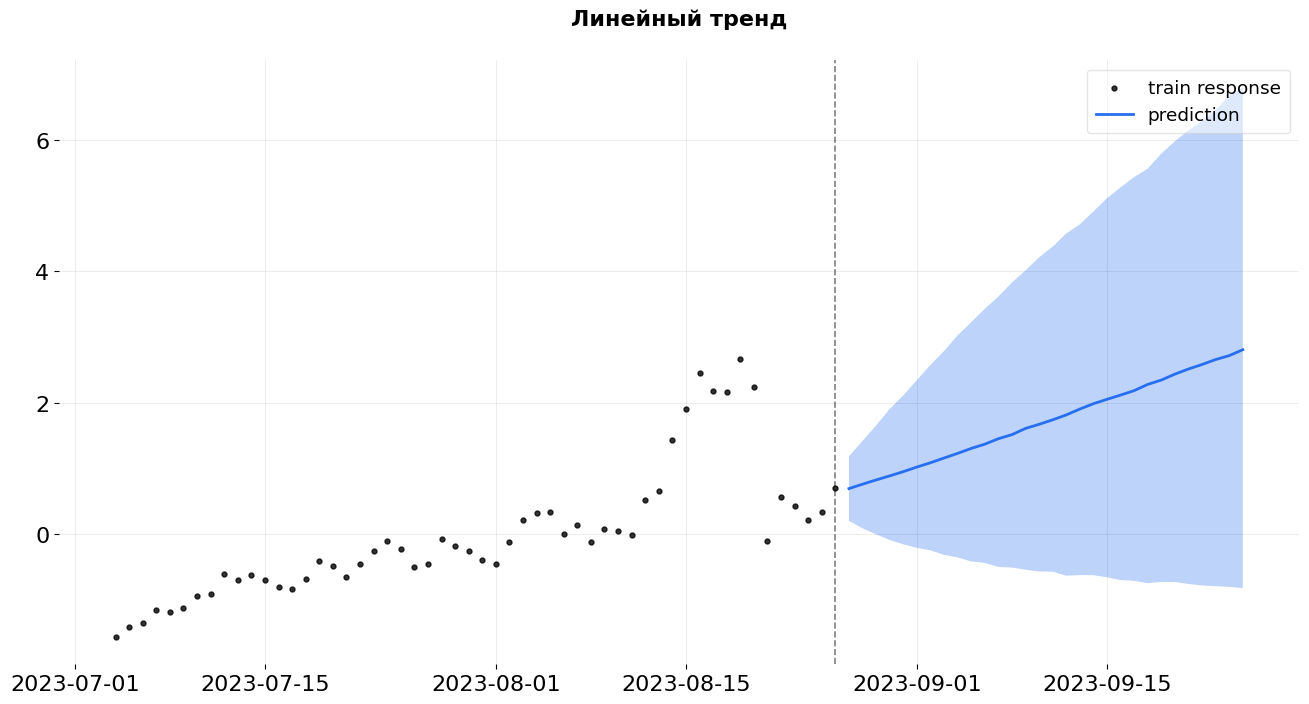

In [90]:
_ = plot_predicted_data(df_act, pred_lin, "time", 'views_stand', title='Линейный тренд')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

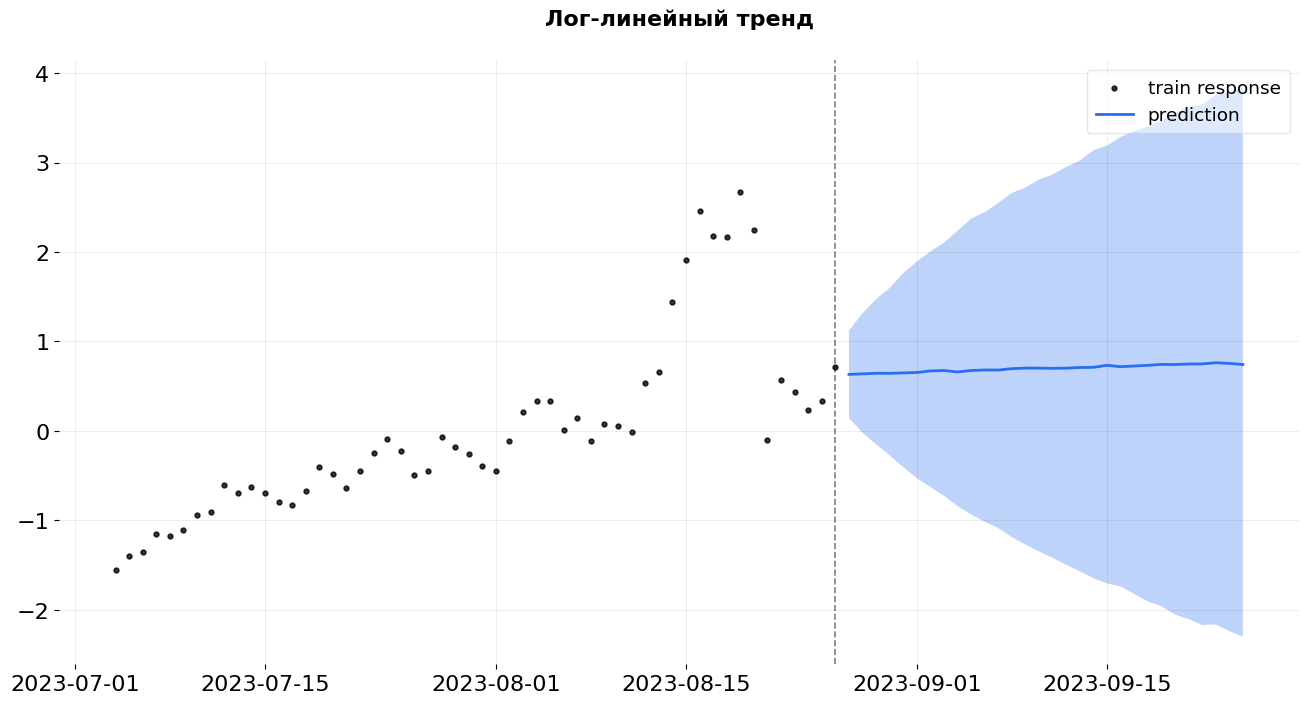

In [91]:
_ = plot_predicted_data(df_act, pred_log, "time", 'views_stand', title='Лог-линейный тренд')

Качество моделей

In [92]:
from orbit.diagnostics.backtest import BackTester

In [93]:
backtester_lin = BackTester(
    model=linear,
    df=df_act,
    min_train_len=7,
    incremental_len=7,
    forecast_len=7,
    window_type="rolling")
    
backtester_lin.fit_predict()

backtester_loglin = BackTester(
    model=loglinear,
    df=df_act,
    min_train_len=7,
    incremental_len=7,
    forecast_len=7,
    window_type="rolling")
    
backtester_loglin.fit_predict()

    
test_list_rolling = [backtester_lin, backtester_loglin]

2023-09-14 17:09:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 17:09:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 17:09:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 17:09:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 17:09:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 17:09:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 17:09:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 17:09:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 17:09:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 17:09:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 17:09:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 17:09:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [94]:
backtester_lin_exp = BackTester(
    model=linear,
    df=df_act,
    min_train_len=7,
    incremental_len=7,
    forecast_len=7,
    window_type="expanding")
    
backtester_lin_exp.fit_predict()

backtester_loglin_exp = BackTester(
    model=loglinear,
    df=df_act,
    min_train_len=7,
    incremental_len=7,
    forecast_len=7,
    window_type="expanding")
    
backtester_loglin_exp.fit_predict()

    
test_list_exp = [backtester_lin_exp, backtester_loglin_exp]

2023-09-14 17:10:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 17:10:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 17:10:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 17:10:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 17:10:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 17:11:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 17:11:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 17:11:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 17:11:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 17:11:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 17:11:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 17:11:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [95]:
roll_df = []

for number, tester in enumerate(test_list_rolling):
    
    inter_df = tester.score()
    inter_df.insert(0, "model_number", number + 1)
    
    roll_df.append(inter_df)
    
roll_df = pd.concat(roll_df)
roll_df = roll_df.set_index("model_number")

In [96]:
roll_df.head()

,metric_name,metric_values,is_training_metric
model_number,,,
1,smape,1.016890,False
1,wmape,0.673787,False
1,mape,4.778889,False
1,mse,0.422544,False
1,mae,0.456177,False


In [97]:
for metric in roll_df.metric_name.unique():
    
    winning_model = roll_df.loc[roll_df.metric_name == metric].metric_values.idxmin()
    
    print(f"Самая лучшая модель по метрике {metric} - {winning_model}")

Самая лучшая модель по метрике smape - 2
Самая лучшая модель по метрике wmape - 2
Самая лучшая модель по метрике mape - 2
Самая лучшая модель по метрике mse - 2
Самая лучшая модель по метрике mae - 2
Самая лучшая модель по метрике rmsse - 2


In [98]:
exp_df = []

for number, tester in enumerate(test_list_exp):
    
    inter_df = tester.score()
    inter_df.insert(0, "model_number", number + 1)
    
    exp_df.append(inter_df)
    
exp_df = pd.concat(exp_df)
exp_df = exp_df.set_index("model_number")

In [99]:
for metric in exp_df.metric_name.unique():
    
    winning_model = exp_df.loc[exp_df.metric_name == metric].metric_values.idxmin()
    
    print(f"Самая лучшая модель по метрике {metric} - {winning_model}")

Самая лучшая модель по метрике smape - 2
Самая лучшая модель по метрике wmape - 2
Самая лучшая модель по метрике mape - 2
Самая лучшая модель по метрике mse - 2
Самая лучшая модель по метрике mae - 2
Самая лучшая модель по метрике rmsse - 2


Лучшая модель по всем метрикам логлинейная и для скользящего окна, и для расширяющегося

Предсказываем значения в будущем

In [76]:
comps = loglinear_fit.predict(futur)

Возвращаем данные в исходную размерность

In [101]:
comps[["prediction_5", "prediction", "prediction_95"]] = comps[["prediction_5", "prediction", "prediction_95"]] \
                         .apply(lambda x: (x * views_sd) + views_mean)

In [102]:
comps.tail()

,time,prediction_5,prediction,prediction_95
25,2023-09-21,-1.942182e+10,1.916079e+11,4.128760e+11
26,2023-09-22,-2.542573e+10,1.907351e+11,4.159724e+11
27,2023-09-23,-3.094022e+10,1.915952e+11,4.227477e+11
28,2023-09-24,-3.497492e+10,1.915816e+11,4.281037e+11
29,2023-09-25,-3.832102e+10,1.914530e+11,4.308866e+11
